In [35]:
import re
import math
import numpy as np
from rich.table import Table
import matplotlib.pyplot as plt
from rich.console import Console
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw, ImageFont
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.rcParams['figure.dpi'] = 300

#============================================================================================================
# Meta Inputs
#============================================================================================================

turb_model    = 'iea10MW'
rotor_model   = 'GAD'

ntasks        = 72

slice_loc     = np.arange(1,5,1)

plot_dom      = True

read_namelist = True

top_directory = '/Users/stormmata/Downloads'


In [36]:
def parse_namelist(file_path):

    file_path = file_path + '/namelists/' + rotor_model.lower() +'_namelist.input'

    config = {}
    current_section = None

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        for line in file:
            # Remove leading/trailing whitespaces and skip empty lines
            line = line.strip()
            if not line:
                continue

            # Detect section headers (e.g., &time_control)
            section_match = re.match(r'^\s*&(\w+)\s*$', line)
            if section_match:
                current_section = section_match.group(1)
                config[current_section] = {}
                continue

            # Skip lines that do not have '=' (likely comments or empty lines)
            if '=' not in line:
                continue

            # Extract key-value pairs from lines
            key, value = [part.strip() for part in line.split('=', 1)]
            value = value.rstrip(',')  # Remove trailing comma
            value = value.strip()  # Strip leading/trailing spaces

            # Handle comma-separated values (if any)
            if ',' in value:
                value = [v.strip() for v in value.split(',')]
            elif value.lower() in ['.true.', '.false.']:  # Handle Boolean values
                value = value.lower() == '.true.'
            else:  # Otherwise treat it as a single value (string or number)
                try:
                    value = float(value) if '.' in value else int(value)
                except ValueError:
                    pass  # Keep it as string if it's not a number

            # Store the parsed value in the section
            if current_section:
                config[current_section][key] = value

    return config

In [37]:
def parse_turbineProperties(file_path):

    file_path = file_path + '/case' + '/windTurbines/' + turb_model + '/turbineProperties.tbl'

    config = {}

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            # Skip empty lines
            if not line:
                continue

            # Check for key-value pairs where value comes first and key is in quotes
            key_value_match = re.match(r'^\s*([\d\.\-]+)\s+"([^"]+)"\s*$', line)
            if key_value_match:
                value = float(key_value_match.group(1))  # Convert value to float
                key = key_value_match.group(2)  # Extract key as string
                config[key] = value  # Store in dictionary with key-value pair

    return config

In [38]:
def parse_turbineLocation(file_path):

    file_path = file_path + '/turbines/' + rotor_model.lower() + '_windturbines-ij.dat'

    data = []

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            # Split the line into individual values based on space
            values = line.split()
            
            # Convert the values into appropriate data types (e.g., float, int)
            data = [float(value) if '.' in value else int(value) for value in values]

    return data

In [39]:
def load_variables(parsed_config, parsed_turbine, parsed_location):

    global outer_dx, outer_dy, inner_dx, inner_dy, outer_e_we, outer_e_sn, ztop, inner_e_we, inner_e_sn, e_vert, \
           i_parent_start, j_parent_start, nproc_x, nproc_y, turb_diameter, hub_diameter, turb_x, turb_y, inflow_loc, hubheight, \
           nSections, nElements
    
    outer_dx       = float(parsed_config['domains'].get('dx', None))
    outer_dy       = float(parsed_config['domains'].get('dy', None))

    inner_dx       = outer_dx / float(parsed_config['domains'].get('parent_grid_ratio', None)[1])
    inner_dy       = outer_dy / float(parsed_config['domains'].get('parent_grid_ratio', None)[1])
        
    outer_e_we     = int(parsed_config['domains'].get('e_we', None)[0])
    outer_e_sn     = int(parsed_config['domains'].get('e_sn', None)[0])
    ztop           = int(parsed_config['domains'].get('ztop', None)[0])
        
    inner_e_we     = int(parsed_config['domains'].get('e_we', None)[1])
    inner_e_sn     = int(parsed_config['domains'].get('e_sn', None)[1])

    e_vert         = int(parsed_config['domains'].get('e_vert', None)[0])

    i_parent_start = int(parsed_config['domains'].get('i_parent_start', None)[1])
    j_parent_start = int(parsed_config['domains'].get('j_parent_start', None)[1])

    nproc_x        = parsed_config['domains'].get('nproc_x', None)
    nproc_y        = parsed_config['domains'].get('nproc_y', None)

    turb_diameter  = float(parsed_turbine['Rotor diameter [m]'])
    hub_diameter   = float(parsed_turbine['Hub diameter [m]'])
    turb_x         = float(parsed_location[0])
    turb_y         = float(parsed_location[1])
    inflow_loc     = float(parsed_turbine['Inflow location [m]'])

    hubheight      = float(parsed_turbine['Hub height [m]'])

    nSections      = int(parsed_config['physics'].get('wind_wtp_nSections', None))
    nElements      = int(parsed_config['physics'].get('wind_wtp_nElements', None))

    return outer_dx, outer_dy, inner_dx, inner_dy, outer_e_we, outer_e_sn, ztop, inner_e_we, inner_e_sn, e_vert, i_parent_start, j_parent_start,turb_diameter, \
           nproc_x, nproc_y, hub_diameter, turb_x, turb_y, inflow_loc, hubheight, nSections, nElements

In [40]:
if read_namelist:
    parsed_namelist = parse_namelist(top_directory)
    parsed_turbine  = parse_turbineProperties(top_directory)
    parsed_location = parse_turbineLocation(top_directory)

    load_variables(parsed_namelist, parsed_turbine, parsed_location)

else:

    hubheight      = 378

    outer_dx       = 40
    inner_dx       = 8
        
    outer_e_we     = 251
    outer_e_sn     = 101
    ztop           = 756
        
    inner_e_we     = 211
    inner_e_sn     = 101

    e_vert         = 187

    i_parent_start = 10
    j_parent_start = 40

    turb_diameter  = 199
    hub_diameter   = 4.8
    turb_x         = 796
    turb_y         = 382
    inflow_loc     = 597

    nSections      = 157
    nElements      = 34
    

In [41]:
# General calculations

#============================================================================================================
# Main logic [generally no edits beyond this point]
#============================================================================================================

outer_length   = outer_e_we * outer_dx       # Length of the outer domain (x-direction)
outer_width    = outer_e_sn * outer_dx       # Width of the outer domain (y-direction)
outer_height   = ztop                        # Height of the outer domain (z-direction)

inner_length   = inner_e_we * inner_dx       # Length of the inner domain (x-direction)
inner_width    = inner_e_sn * inner_dx       # Width of the inner domain (y-direction)
inner_height   = ztop                        # Height of the inner domain (z-direction)
inner_i        = i_parent_start * outer_dx   # Inner domain x-offset from the origin of the outer domain
inner_j        = j_parent_start * outer_dx   # Inner domain y-offset from the origin of the outer domain

turbine_radius = turb_diameter / 2           # Radius of the wind turbine circle

def distribute_processors(num_processors):
    # Find the closest square grid dimensions that use all processors
    rows = int(math.sqrt(num_processors))
    cols = num_processors // rows
    
    # Adjust to ensure all processors are used
    if rows * cols < num_processors:
        cols += 1  # Increase columns if the product is less than the number of processors
    
    # Calculate how many processors will be in each block
    return rows, cols

# Call the function to distribute the processors

if (nproc_x == None) & (nproc_y == None):
    rows, cols = distribute_processors(ntasks)
else:
    rows = int(nproc_y)
    cols = int(nproc_x)

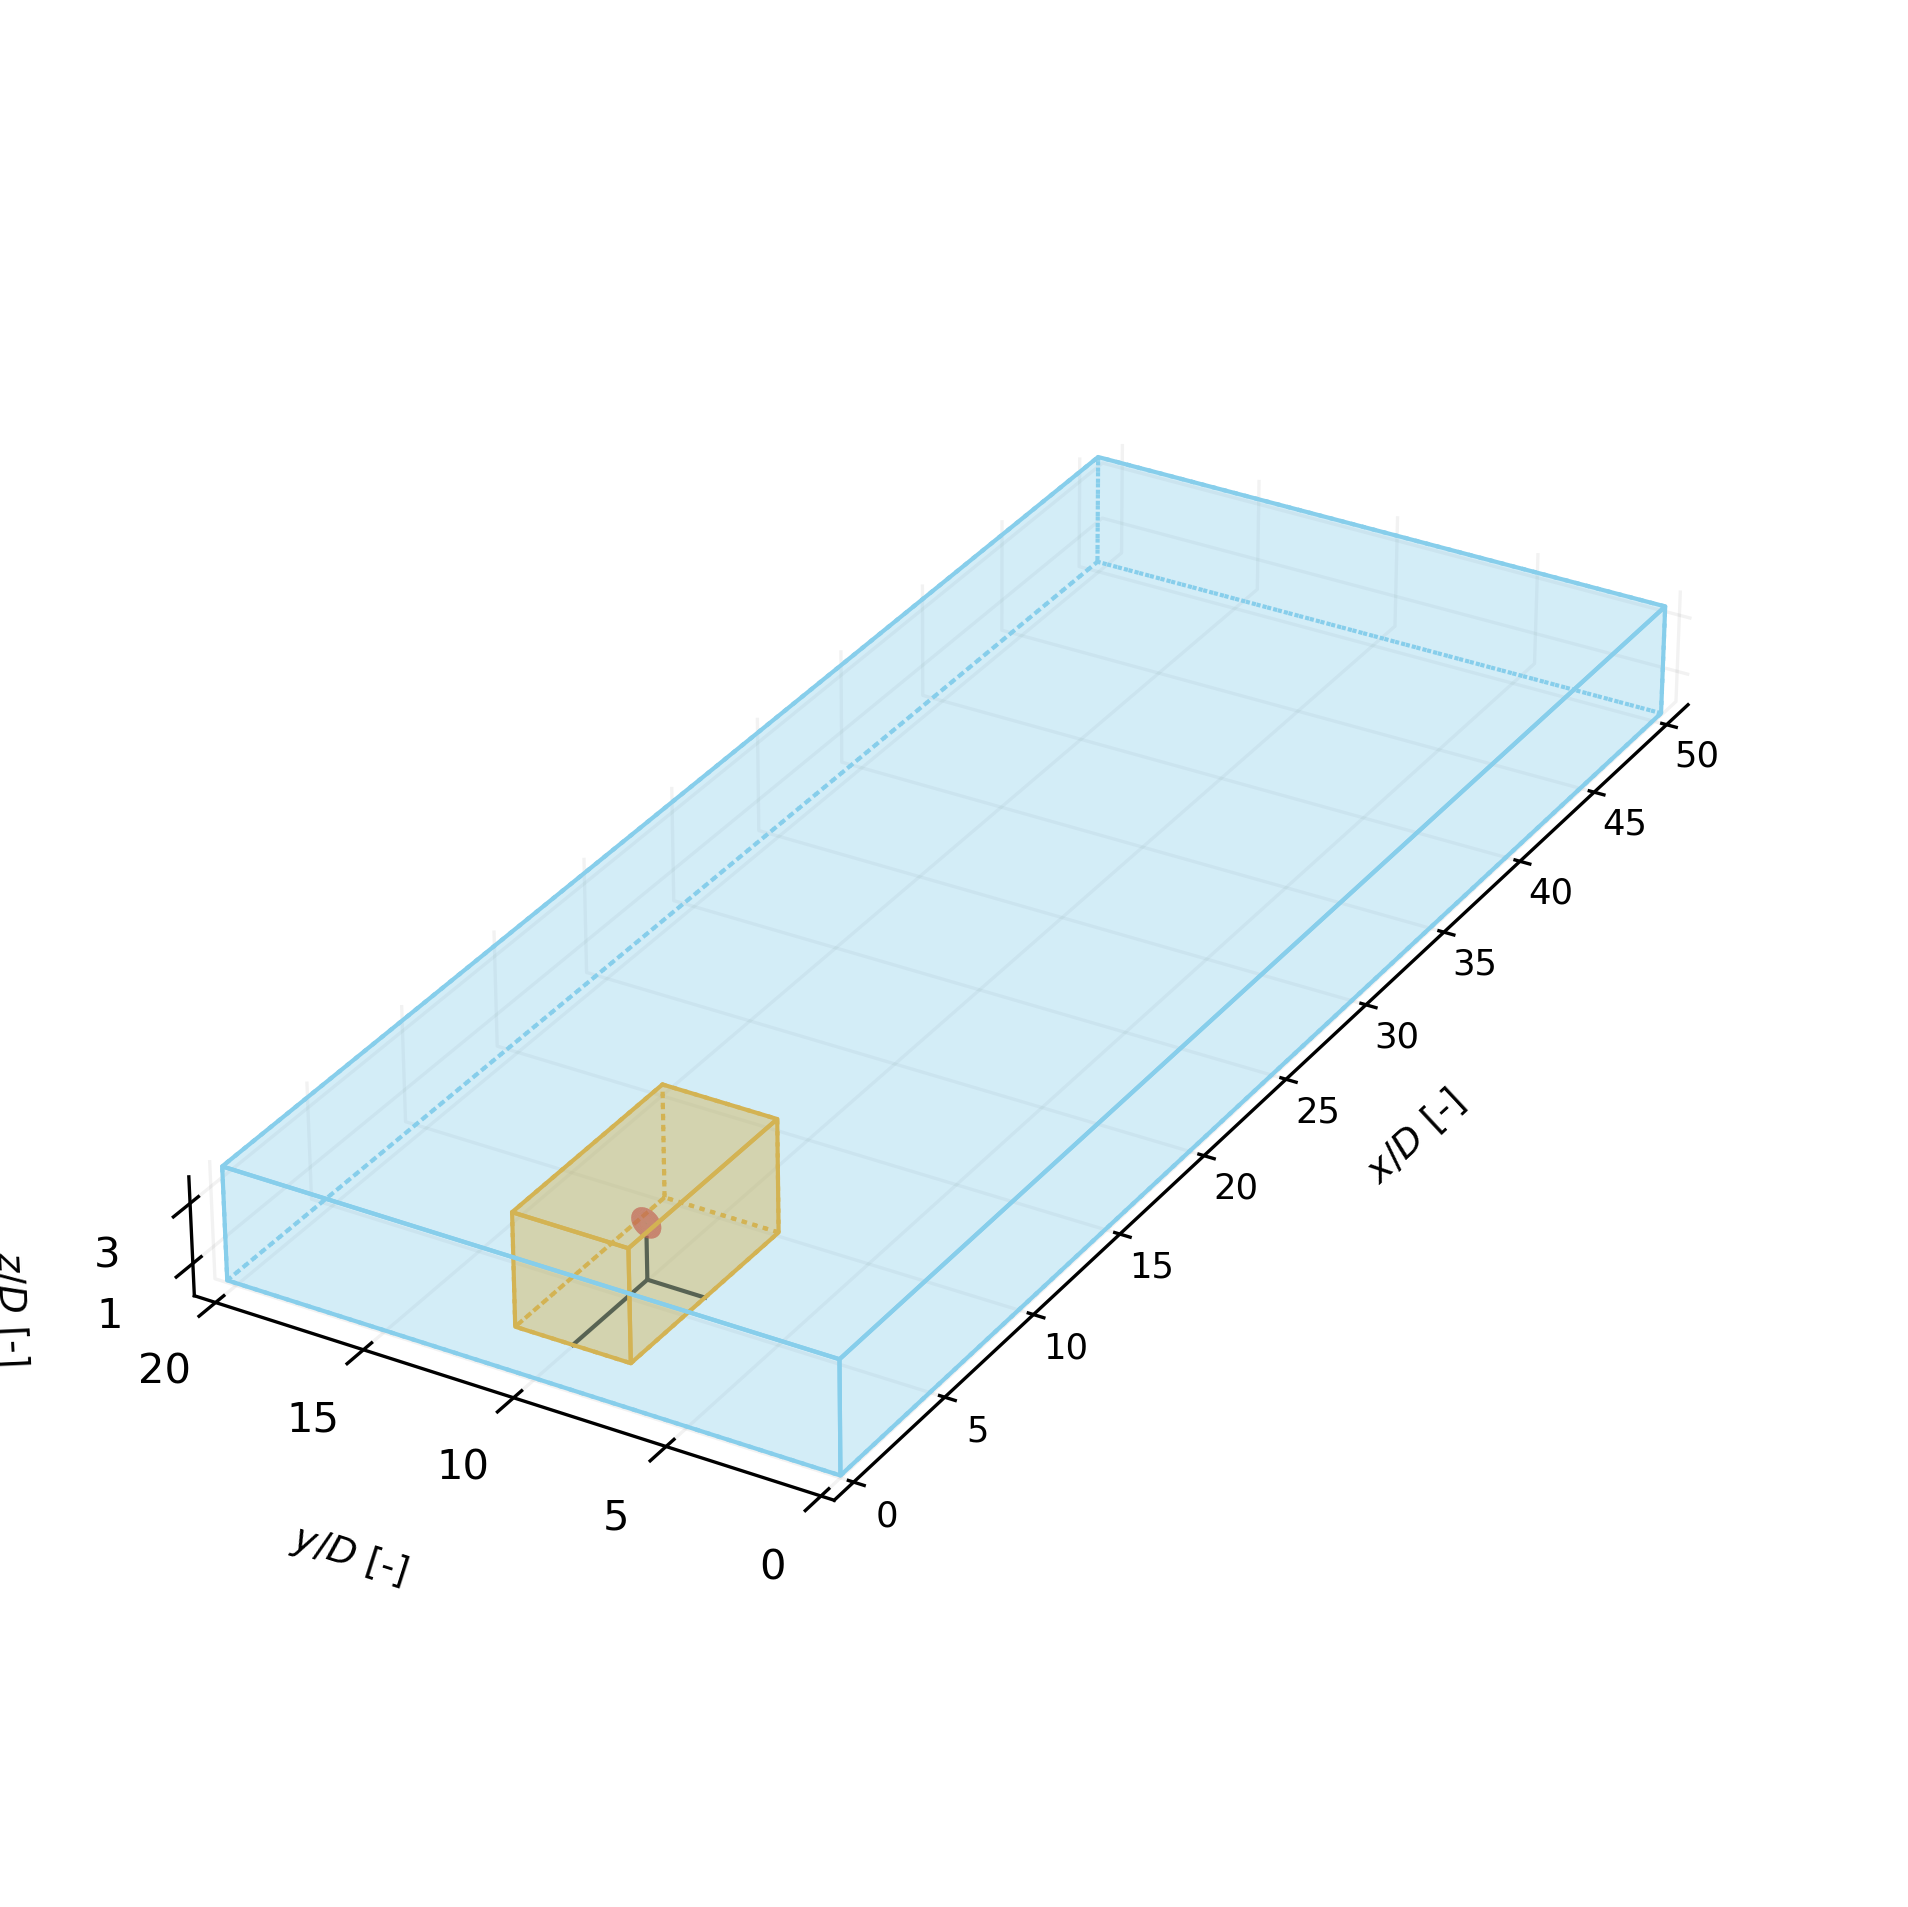

In [42]:
# Plot outer domain

if plot_dom:
    # Define 3D figure
    fig = plt.figure(figsize=(8, 8))  # Width = 10 inches, Height = 8 inches

    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

    # Draw outer domain as a cuboid
    outer_corners = [
        [0, 0, 0], [outer_length, 0, 0], [outer_length, outer_width, 0], [0, outer_width, 0],
        [0, 0, outer_height], [outer_length, 0, outer_height], [outer_length, outer_width, outer_height], [0, outer_width, outer_height]
    ]

    faces_outer = [[outer_corners[j] for j in [0, 1, 5, 4]],
                [outer_corners[j] for j in [3, 0, 4, 7]],
                [outer_corners[j] for j in [4, 5, 6, 7]]]
    ax.add_collection3d(Poly3DCollection(faces_outer, color='skyblue', alpha=0.2, linewidths=1, edgecolors='b', zorder=7))


    faces_outer = [[outer_corners[j] for j in [1, 2, 6, 5]],
                [outer_corners[j] for j in [2, 3, 7, 6]],
                [outer_corners[j] for j in [0, 1, 2, 3]]]
    ax.add_collection3d(Poly3DCollection(faces_outer, color='skyblue', alpha=0.2, linewidths=1, linestyle=':', edgecolors='b', zorder=7))

    # Calculate inner domain position
    inner_x_start = inner_i
    inner_y_start = inner_j
    inner_z_start = 0  # Assume inner domain is at the base of the outer domain

    # Draw inner domain as a smaller cuboid within the outer domain
    inner_corners = [
        [inner_x_start, inner_y_start, inner_z_start],
        [inner_x_start + inner_length, inner_y_start, inner_z_start],
        [inner_x_start + inner_length, inner_y_start + inner_width, inner_z_start],
        [inner_x_start, inner_y_start + inner_width, inner_z_start],
        [inner_x_start, inner_y_start, inner_z_start + inner_height],
        [inner_x_start + inner_length, inner_y_start, inner_z_start + inner_height],
        [inner_x_start + inner_length, inner_y_start + inner_width, inner_z_start + inner_height],
        [inner_x_start, inner_y_start + inner_width, inner_z_start + inner_height]
    ]
    faces_inner = [[inner_corners[j] for j in [0, 1, 5, 4]],
                [inner_corners[j] for j in [3, 0, 4, 7]],
                [inner_corners[j] for j in [4, 5, 6, 7]]]
    ax.add_collection3d(Poly3DCollection(faces_inner, color='orange', alpha=0.25, linewidths=1, edgecolors='r',zorder=6))


    faces_inner = [[inner_corners[j] for j in [1, 2, 6, 5]],
                [inner_corners[j] for j in [2, 3, 7, 6]],
                [inner_corners[j] for j in [0, 1, 2, 3]]]
    ax.add_collection3d(Poly3DCollection(faces_inner, color='orange', alpha=0.25, linestyle=':', linewidths=1, edgecolors='r',zorder=1))

    # Draw turbine circle within the inner domain
    turbine_center_x = inner_x_start + turb_x
    turbine_center_y = inner_y_start + turb_y
    turbine_center_z = hubheight

    # Generate points for a filled disk
    theta = np.linspace(0, 2 * np.pi, 100)  # Angle for full circle
    radii = np.linspace(0, turbine_radius, 50)  # Radii from center to edge of disk

    # Generate grid of points for the disk
    x_circle = np.full((len(radii), len(theta)), turbine_center_x)  # Constant X-coordinate for the disk
    y_circle = turbine_center_y + np.outer(radii, np.cos(theta))
    z_circle = turbine_center_z + np.outer(radii, np.sin(theta))

    # Plotting
    ax.plot_surface(x_circle, y_circle, z_circle, color='red', alpha=1.0, zorder=5)

    # Plot vertical line from the disk down to z = 0
    ax.plot([turbine_center_x, turbine_center_x], [turbine_center_y, turbine_center_y], [turbine_center_z - turb_diameter/2, 0], color='black', linewidth=1, zorder=2)
    ax.plot([turbine_center_x, inner_i], [turbine_center_y, turbine_center_y], [0, 0], color='black', linewidth=1, zorder=3)
    ax.plot([turbine_center_x, turbine_center_x], [turbine_center_y, inner_j], [0, 0], color='black', linewidth=1, zorder=4)

    # Set x-ticks at increments of turbine diameter
    x_ticks = np.arange(0, outer_length + turb_diameter, turb_diameter * 5)
    x_labels = [f"{int(turb / turb_diameter)}" for turb in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, fontsize=8.5)
    # Set y-ticks at increments of turbine diameter
    y_ticks = np.arange(0, outer_length + turb_diameter, turb_diameter * 5)
    y_labels = [f"{int(turb / turb_diameter)}" for turb in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=10)

    z_ticks = [turb_diameter, turb_diameter * 3]
    z_labels = ['1','3']  # Format with one decimal point

    ax.set_zticks(z_ticks)
    ax.set_zticklabels(z_labels, fontsize=10)

    # Set plot limits to show only the outer domain
    ax.set_xlim([0, outer_length])
    ax.set_ylim([0, outer_width])
    ax.set_zlim([0, outer_height])

    # Set labels
    ax.set_xlabel(r'$x/D$ [-]', labelpad=25, fontsize=9)
    ax.set_ylabel(r'$y/D$ [-]', labelpad=15, fontsize=9)
    ax.set_zlabel(r'$z/D$ [-]', fontsize=9)

    # Change the camera angle
    ax.view_init(elev=30, azim=-150)
    # ax.view_init(elev=9, azim=-170)
    # ax.view_init(elev=0, azim=90)
    # ax.view_init(elev=90, azim=-90)

    plt.gca().set_aspect('equal', adjustable='box')

    # Set the alpha for grid lines on each axis in a 3D plot
    ax.xaxis._axinfo["grid"].update({"color": (0.5, 0.5, 0.5, 0.10)})  # 30% opacity for x-axis grid
    ax.yaxis._axinfo["grid"].update({"color": (0.5, 0.5, 0.5, 0.10)})  # 30% opacity for y-axis grid
    ax.zaxis._axinfo["grid"].update({"color": (0.5, 0.5, 0.5, 0.10)})  # 30% opacity for z-axis grid

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent background for x-axis pane
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent background for y-axis pane
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent background for z-axis pane

    # plt.axis('off')
    
    plt.savefig("domain.png", dpi=500, bbox_inches='tight')

    plt.show()

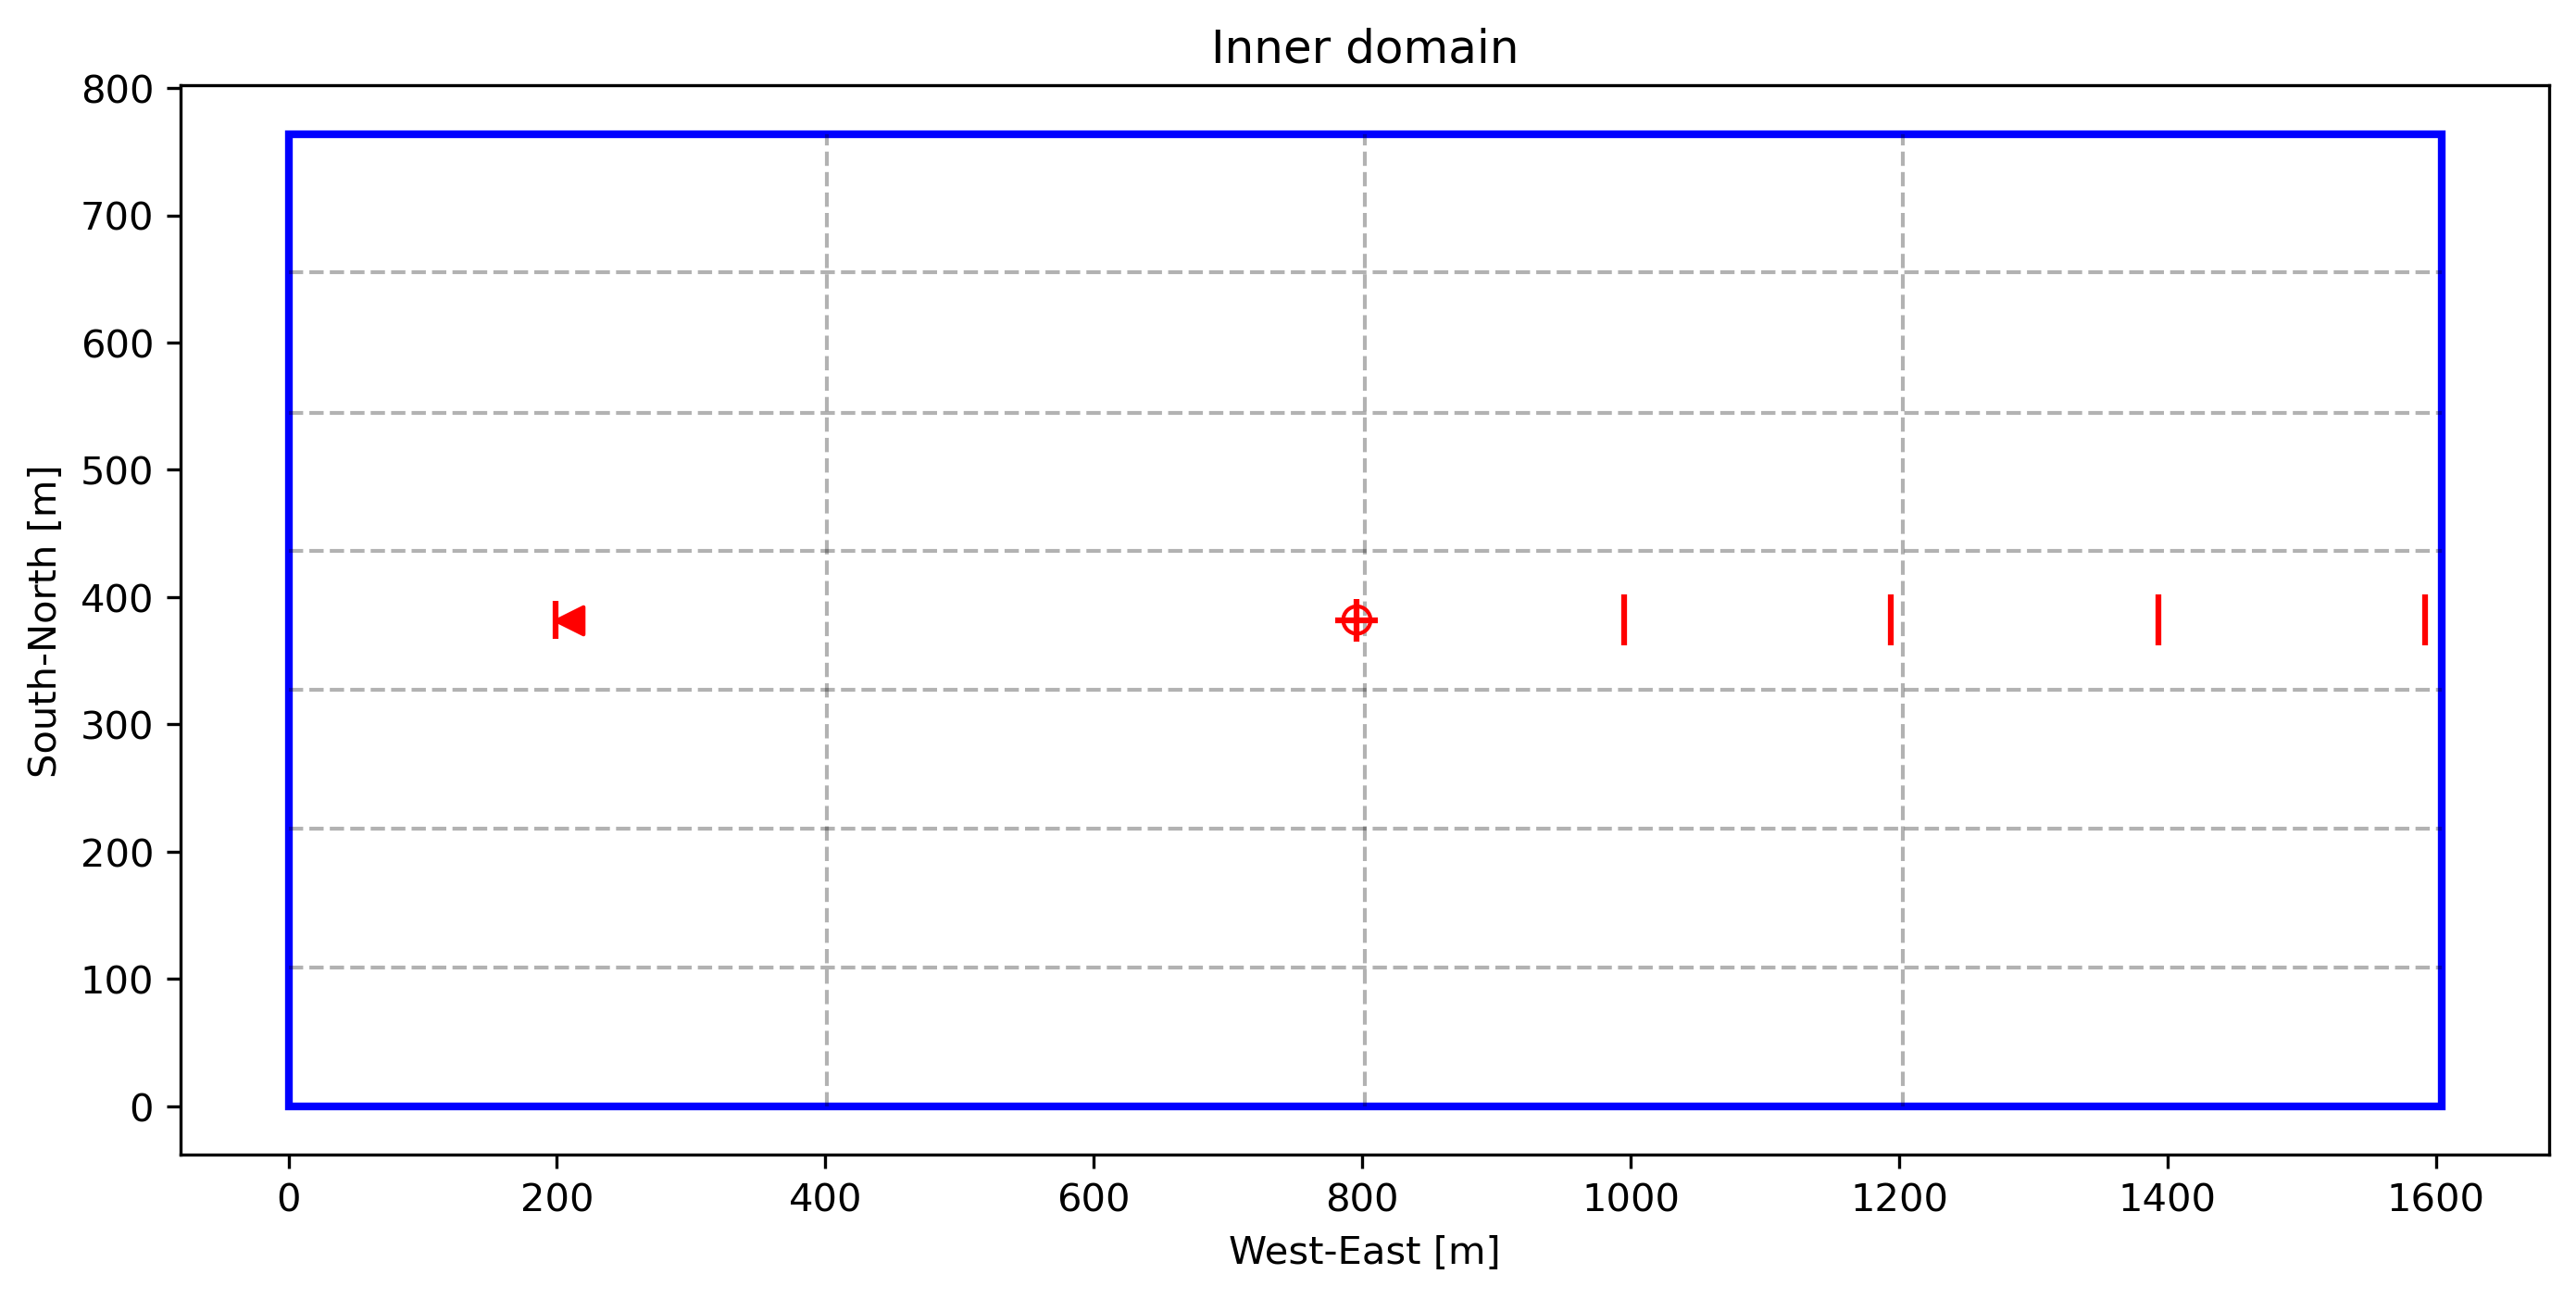

In [43]:
# Plot inner domain

# Calculating rectangle dimensions
x = inner_e_we * inner_dx  # Width of the rectangle
y = inner_e_sn * inner_dx  # Height of the rectangle

# Add the outer rectangle to the plot
rect = Rectangle((0, 0), x, y, edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(rect)

cols = 4
rows = 7

slices = turb_x + np.array(slice_loc) * turb_diameter

# Calculate step sizes (rounded down to integers)
dx = int(x // cols)  # Integer width of each internal column
dy = int(y // rows)  # Integer height of each internal row

# Calculate the leftover space
leftover_x = x - (dx * cols)
leftover_y = y - (dy * rows)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(11, 5))

# Add the outer rectangle to the plot
rect = Rectangle((0, 0), x, y, edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(rect)

# Draw the vertical dividing lines
for i in range(1, cols):
    x_pos = i * dx
    if i == cols - 1:  # Extend the final column to include leftover_x
        x_pos += leftover_x
    ax.plot([x_pos, x_pos], [0, y], color='black', linestyle='--', linewidth=1, alpha=0.3)

# Draw the horizontal dividing lines
for j in range(1, rows):
    y_pos = j * dy
    if j == rows - 1:  # Extend the final row to include leftover_y
        y_pos += leftover_y
    ax.plot([0, x], [y_pos, y_pos], color='black', linestyle='--', linewidth=1, alpha=0.3)

ax.scatter(turb_x, turb_y, color='none', edgecolors='red', s=50, label="Single Point", zorder=2)
ax.scatter(turb_x, turb_y, color='red', s=125, marker='+', label="Single Point", zorder=2)

if turb_x < inflow_loc:
    ax.scatter(0, turb_y, color='red', s=50, marker='<', label="Single Point", zorder=2)
else:
    ax.scatter(turb_x - inflow_loc + 10, turb_y, color='red', s=50, marker='<', label="Single Point", zorder=2)
    ax.vlines(turb_x - inflow_loc, turb_y - 15, turb_y + 15, colors='red', linestyles='-')

ax.vlines(slices, turb_y - turb_diameter*0.10, turb_y + turb_diameter*0.10, colors='red', linestyles='-')


# Set axis limits
# ax.set_xlim(-1, x + 1)
# ax.set_ylim(-1, y + 1)

# Set labels and title
ax.set_xlabel("West-East [m]")
ax.set_ylabel("South-North [m]")
ax.set_title("Inner domain")

# Show the plot
plt.show()

In [44]:
# Table

outer_grid = outer_e_sn * outer_e_we * ztop
inner_grid = inner_e_sn * inner_e_we * ztop

# Define the console for rich output
console = Console(record=True)

# Create a rich table
table = Table(title="Simulation Parameters")

# Add columns
table.add_column("Parameter", justify="left", no_wrap=True)
table.add_column("Value", justify="right", style="#66f5ff")
table.add_column("Issue", justify="right", style="#fa1c0c")
ntasks_min  = max([outer_e_sn/100 * outer_e_we/100, 10])
ntasks_max = inner_e_sn/25 * inner_e_we/25

# Add rows with your parameters and values
table.add_row("Turbine model", f"{turb_model}", "")
table.add_row("Turbine diameter", f"{turb_diameter} m", "")
table.add_row("Hub diameter", f"{hub_diameter} m", "")
table.add_row("Rotor model", f"{rotor_model}", "")
table.add_row("", "", "")
table.add_row("Outer domain mesh size", f"{outer_grid:,.0f}", "")
table.add_row("Inner domain mesh Size", f"{inner_grid:,.0f}", "")
table.add_row("Domain mesh ratio", f"{(inner_grid / outer_grid):.2f}", "")
if (ntasks < ntasks_min) | (ntasks > ntasks_max):
    table.add_row("Processes", f"{ntasks:.0f}", f"[{ntasks_min:.0f}, {ntasks_max:.0f}]")
else:
    table.add_row("Processes", f"{ntasks:.0f}", "")
table.add_row("", "", "")
table.add_row("Outer dx, dy", f"[{(outer_dx):.1f}, {(outer_dy):.1f}] m", "")
table.add_row("Inner dx, dy", f"[{(inner_dx):.1f}, {(inner_dy):.1f}] m", "")
table.add_row("dz", f"{(ztop / e_vert):.2f} m", "")
table.add_row("", "", "")
table.add_row("Outer domain [Lx, Ly, Lz]", f"[{(outer_e_we * outer_dx / turb_diameter):.1f}, {(outer_e_sn * outer_dx / turb_diameter):.1f}, {(ztop / turb_diameter):.1f}] x D", "")
table.add_row("Inner domain [Lx, Ly, Lz]", f"[{(inner_e_we * inner_dx / turb_diameter):.1f}, {(inner_e_sn * inner_dx / turb_diameter):.1f}, {(ztop / turb_diameter):.1f}] x D", "")
table.add_row("", "", "")
table.add_row("Outer domain [Nx, Ny, Nz]", f"[{(outer_e_we):.0f}, {(outer_e_sn):.0f}, {(e_vert):.0f}]", "")
table.add_row("Inner domain [Nx, Ny, Nz]", f"[{(inner_e_we):.0f}, {(inner_e_sn):.0f}, {(e_vert):.0f}]", "")
table.add_row("", "", "")
table.add_row("Inner domain x location", f"{(inner_i / turb_diameter):.2f} x D", "")
table.add_row("Turbine x location", f"{(turbine_center_x /turb_diameter):.2f} x D", "")
if (hubheight != (ztop/2)):
    table.add_row("Turbine z location", f"{hubheight:.1f} m", f">{(ztop/2):.2f}")
else:
    table.add_row("Turbine z location", f"{hubheight:.1f} m", "")
table.add_row("", "", "")
nSecmin = np.ceil(np.pi / (np.arcsin(inner_dx / turb_diameter)))
if (nSections < nSecmin):
    table.add_row("Rotor sections", f"{nSections:.0f}", f">{nSecmin:.0f}")
else:
    table.add_row("Rotor sections", f"{nSections:.0f}", "")
nElmin = np.ceil(turb_diameter/2 / inner_dx)
if (nElements < nElmin):
    table.add_row("Rotor elements", f"{nElements:.0f}", f">{nElmin:.0f}")
else:
    table.add_row("Rotor elements", f"{nElements:.0f}", "")

# Print the table to the console
console.print(table)

                    Simulation Parameters                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Parameter                 ┃                 Value ┃ Issue ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Turbine model             │               iea10MW │       │
│ Turbine diameter          │               199.0 m │       │
│ Hub diameter              │                 4.8 m │       │
│ Rotor model               │                   GAD │       │
│                           │                       │       │
│ Outer domain mesh size    │            19,165,356 │       │
│ Inner domain mesh Size    │            57,902,796 │       │
│ Domain mesh ratio         │                  3.02 │       │
│ Processes                 │                    72 │       │
│                           │                       │       │
│ Outer dx, dy              │        [40.0, 40.0] m │       │
│ Inner dx, dy              │          [4.0, 4.0] m │       │
│ dz                        │                4.04 m │       │
│                           │                       │       │
│ Outer domain [Lx, Ly, Lz] │ [50.5, 20.3, 3.8] x D │       │
│ Inner domain [Lx, Ly, Lz] │   [8.1, 3.8, 3.8] x D │       │
│                           │                       │       │
│ Outer domain [Nx, Ny, Nz] │       [251, 101, 187] │       │
│ Inner domain [Nx, Ny, Nz] │       [401, 191, 187] │       │
│                           │                       │       │
│ Inner domain x location   │              2.01 x D │       │
│ Turbine x location        │              6.01 x D │       │
│ Turbine z location        │               378.0 m │       │
│                           │                       │       │
│ Rotor sections            │                   157 │       │
│ Rotor elements            │                    25 │       │
└───────────────────────────┴───────────────────────┴───────┘

In [27]:
# Create summary image

dpi = 500

text = console.export_text()

# Load a monospaced TrueType font
font = ImageFont.truetype("/Users/stormmata/Library/Fonts/DejaVuSansMono.ttf", 12)  # Adjust path as needed

# Calculate dimensions for the image
padding = 10
lines = text.splitlines()

# Calculate the image dimensions
width = max(font.getbbox(line)[2] for line in lines) + 2 * padding
line_height = font.getbbox(lines[0])[3]
height = line_height * len(lines) + 2 * padding

# Increase the image resolution (scale up the pixel size)
scale_factor = dpi / 25  # Assuming default resolution is 72 DPI
new_width = int(width * scale_factor)
new_height = int(height * scale_factor)
new_line_height = int(line_height * scale_factor)
new_padding = int(padding * scale_factor)

# Create a new image with white background
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# Draw text onto the image
for i, line in enumerate(lines):
    draw.text((padding, padding + i * line_height), line, fill="black", font=font)

# Save the image as PNG
image.save("rich_table.png", dpi=(dpi,dpi))


# Load the two images you want to combine
image1 = Image.open("domain.png")
image2 = Image.open("rich_table.png")

scale = 6

# Double the size of image2
image2 = image2.resize((image2.width * scale, image2.height * scale), Image.LANCZOS)

# Calculate the dimensions of the new combined image
new_width = image1.width + image2.width
new_height = max(image1.height, image2.height)

# Create a new blank (white) image with the required dimensions
combined_image = Image.new("RGB", (new_width, new_height), "white")

# Calculate vertical padding for each image if their heights differ
image1_y_offset = (new_height - image1.height) // 2
image2_y_offset = (new_height - image2.height) // 2

# Paste image1 on the left with vertical centering
combined_image.paste(image1, (0, image1_y_offset))

# Paste image2 on the right with vertical centering
combined_image.paste(image2, (image1.width, image2_y_offset))

# Save the combined image
combined_image.save("combined_image.png", dpi=(500,500))